In [1]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# Constants
PLAYER_X = 1
PLAYER_O = -1
EMPTY = 0
ALPHA = 0.1     # Learning rate
GAMMA = 0.9     # Discount factor
EPSILON = 0.1   # Exploration rate
BOARD_SIZE_4x4 = 4
BOARD_SIZE_5x5 = 5
  # Board size for Tic Tac Toe (3x3)
REPLAY_BUFFER_SIZE = 2000
BATCH_SIZE = 32

# Create an empty board
def create_board(size):
    return np.zeros((size, size), dtype=int)

# Check for a winner
def check_winner(board):
    size = board.shape[0]
    for player in [PLAYER_X, PLAYER_O]:
        for i in range(size):
            if all(board[i, :] == player) or all(board[:, i] == player):
                return player
        if all([board[i, i] == player for i in range(size)]) or all([board[i, size - 1 - i] == player for i in range(size)]):
            return player
    if np.all(board != EMPTY):
        return 0  # Draw
    return None  # Game not finished

class DeepQLearningAgent:
    def __init__(self, size):
        self.size = size
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        
        self.replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)
        self.epsilon = EPSILON
    
    def build_model(self):
        """Build the neural network for Q-value approximation."""
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(self.size, self.size)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.size * self.size)  # Output Q-value for each cell in the board
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), loss='mse')
        return model

    def update_target_model(self):
        """Copy weights from the main model to the target model."""
        self.target_model.set_weights(self.model.get_weights())
    
    def get_possible_actions(self, board):
        """Get a list of possible actions (empty cells)."""
        return list(zip(*np.where(board == EMPTY)))

    def choose_action(self, board):
        """Epsilon-greedy policy to choose the next action."""
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            return random.choice(self.get_possible_actions(board))
        
        # Exploit: choose the best action based on Q-values
        q_values = self.model.predict(board.reshape(1, self.size, self.size), verbose=0)
        q_values = q_values.reshape(self.size, self.size)
        
        # Mask invalid actions (filled cells)
        possible_actions = self.get_possible_actions(board)
        best_action = max(possible_actions, key=lambda x: q_values[x[0], x[1]])
        return best_action

    def remember(self, state, action, reward, next_state, done):
        """Store experience in the replay buffer."""
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def replay(self):
        """Train the model using experiences sampled from the replay buffer."""
        if len(self.replay_buffer) < BATCH_SIZE:
            return

        minibatch = random.sample(self.replay_buffer, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_q_values = self.target_model.predict(next_state.reshape(1, self.size, self.size), verbose=0)
                target = reward + GAMMA * np.max(next_q_values)
            
            # Update the Q-value for the chosen action
            q_values = self.model.predict(state.reshape(1, self.size, self.size), verbose=0)
            q_values[0][action[0] * self.size + action[1]] = target
            
            # Train the model
            self.model.fit(state.reshape(1, self.size, self.size), q_values, epochs=1, verbose=0)

    def play_game(self, opponent='random'):
        """Simulate a game between the DQL agent and a random opponent."""
        board = create_board(self.size)
        player = PLAYER_X
        state = board.copy()

        while True:
            if player == PLAYER_X:
                action = self.choose_action(board)
            else:
                action = random.choice(self.get_possible_actions(board)) if opponent == 'random' else self.choose_action(board)

            board[action] = player
            next_state = board.copy()
            winner = check_winner(board)
            
            reward = 1 if winner == PLAYER_X else -1 if winner == PLAYER_O else 0
            done = winner is not None
            
            self.remember(state, action, reward, next_state, done)

            if done:
                return reward
            
            if player == PLAYER_X:
                self.replay()

            state = next_state
            player = -player

    def train(self, episodes, target_update_interval=10):
        win_count = 0
        win_rates = []

        for episode in range(episodes):
            if self.play_game() == 1:
                win_count += 1

            if (episode + 1) % target_update_interval == 0:
                self.update_target_model()
            if (episode + 1) % 100 == 0:
                win_rate = win_count / (episode + 1)
                win_rates.append(win_rate)
                print(f"Episode {episode + 1}: Win rate = {win_rate:.3f}")

        return win_rates

def plot_win_rate(win_rates, board_size):
    plt.plot(win_rates)
    plt.xlabel('Episodes (x100)')
    plt.ylabel('Win Rate')
    plt.title(f'Agent Win Rate Over Time (Board Size: {board_size}x{board_size})')
    plt.show()

Episode 100: Win rate = 0.320
Episode 200: Win rate = 0.315
Episode 300: Win rate = 0.310
Episode 400: Win rate = 0.305
Episode 500: Win rate = 0.310
Episode 600: Win rate = 0.325
Episode 700: Win rate = 0.337
Episode 800: Win rate = 0.340
Episode 900: Win rate = 0.346
Episode 1000: Win rate = 0.341


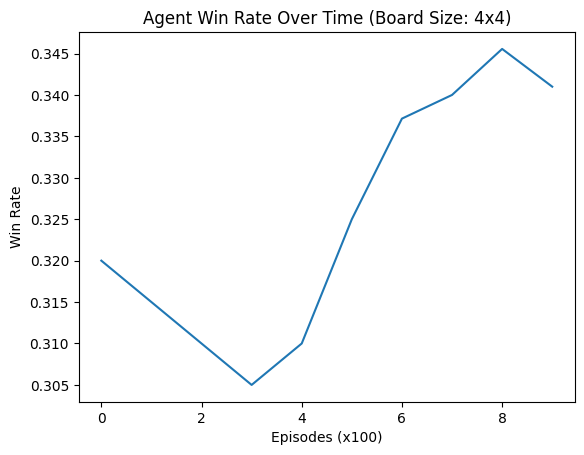

Episode 100: Win rate = 0.150
Episode 200: Win rate = 0.145
Episode 300: Win rate = 0.150
Episode 400: Win rate = 0.142
Episode 500: Win rate = 0.178


In [ ]:
if __name__ == '__main__':

    agent_4x4 = DeepQLearningAgent(BOARD_SIZE_4x4)
    win_rate_4x4 = agent_4x4.train(1000)
    
    # Plotting win rate\
    plot_win_rate(win_rate_4x4, BOARD_SIZE_4x4)

    # Train and plot for 5x5 board
    agent_5x5 = DeepQLearningAgent(BOARD_SIZE_5x5)
    win_rates_5x5 = agent_5x5.train(1000)
    plot_win_rate(win_rates_5x5, BOARD_SIZE_5x5)